In [23]:
#import potrebnih biblioteka
%matplotlib inline
import cv2
import numpy as np 
import matplotlib.pyplot as plt 
import collections

# keras
from keras.models import Sequential
from keras.layers.core import Dense,Activation
from keras.optimizers import SGD

import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 12 # za prikaz većih slika i plotova, zakomentarisati ako nije potrebno

In [24]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret,image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
def dilate(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)
def erode(image):
    kernel = np.ones((3,3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)
def resize_region(region):
    '''Transformisati selektovani region na sliku dimenzija 28x28'''
    return cv2.resize(region,(28,28), interpolation = cv2.INTER_NEAREST)
def select_roi(image_orig, image_bin):
    '''Oznaciti regione od interesa na originalnoj slici. (ROI = regions of interest)
        Za svaki region napraviti posebnu sliku dimenzija 28 x 28. 
        Za označavanje regiona koristiti metodu cv2.boundingRect(contour).
        Kao povratnu vrednost vratiti originalnu sliku na kojoj su obeleženi regioni
        i niz slika koje predstavljaju regione sortirane po rastućoj vrednosti x ose
    '''
    img, contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po x osi (sa leva na desno)
    regions_dic = {}
    for contour in contours: 
        x,y,w,h = cv2.boundingRect(contour) #koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 5 and w > 15:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # označiti region pravougaonikom na originalnoj slici (image_orig) sa rectangle funkcijom
            region = image_bin[y:y+h+1,x:x+w+1];
            regions_dic[x] = resize_region(region)       
            cv2.rectangle(image_orig,(x,y),(x+w,y+h),(0,255,0),2)
    
    sorted_regions_dic = collections.OrderedDict(sorted(regions_dic.items()))
    sorted_regions = sorted_regions_dic.values()
            
    # sortirati sve regione po x osi (sa leva na desno) i smestiti u promenljivu sorted_regions
    return image_orig, sorted_regions
def scale_to_range(image): # skalira elemente slike na opseg od 0 do 1
    ''' Elementi matrice image su vrednosti 0 ili 255. 
        Potrebno je skalirati sve elemente matrica na opseg od 0 do 1
    '''
    return image/255
def matrix_to_vector(image):
    '''Sliku koja je zapravo matrica 28x28 transformisati u vektor sa 784 elementa'''
    return image.flatten()
def prepare_for_ann(regions):
    '''Regioni su matrice dimenzija 28x28 čiji su elementi vrednosti 0 ili 255.
        Potrebno je skalirati elemente regiona na [0,1] i transformisati ga u vektor od 784 elementa '''
    ready_for_ann = []
    for region in regions:
        # skalirati elemente regiona (metoda iz TODO 3 scale_to_range)
        # region sa skaliranim elementima pretvoriti u vektor (metoda iz TODO 4 matrix_to_vector)
        # vektor dodati u listu spremnih regiona
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
        
    return ready_for_ann
def convert_output(alphabet):
    '''Konvertovati alfabet u niz pogodan za obučavanje NM,
        odnosno niz čiji su svi elementi 0 osim elementa čiji je
        indeks jednak indeksu elementa iz alfabeta za koji formiramo niz.
        Primer prvi element iz alfabeta [1,0,0,0,0,0,0,0,0,0],
        za drugi [0,1,0,0,0,0,0,0,0,0] itd..
    '''
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)
def winner(output): # output je vektor sa izlaza neuronske mreze
    '''pronaći i vratiti indeks neurona koji je najviše pobuđen'''
    return max(enumerate(output), key=lambda x: x[1])[0]


60000 train samples
10000 test samples


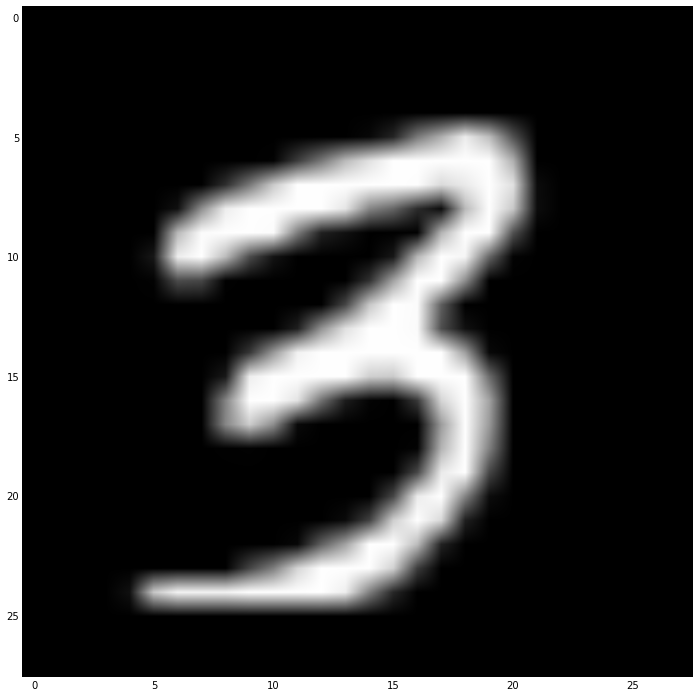

In [36]:
'''Train a simple deep NN on the MNIST dataset.
Get to 98.40% test accuracy after 20 epochs
(there is *a lot* of margin for parameter tuning).
2 seconds per epoch on a K520 GPU.
'''

from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

batch_size = 128
nb_classes = 10
nb_epoch = 20

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

display_image(X_train[983])

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

#model = Sequential()
#model.add(Dense(512, input_shape=(784,)))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
#model.add(Dense(10))
#model.add(Activation('softmax'))

#rms = RMSprop()
#model.compile(loss='categorical_crossentropy', optimizer=rms)

#model.fit(X_train, Y_train,
#          batch_size=batch_size, nb_epoch=nb_epoch,
#          show_accuracy=True, verbose=2,
#          validation_data=(X_test, Y_test))
#score = model.evaluate(X_test, Y_test,
#                       show_accuracy=True, verbose=0)
#print('Test score:', score[0])
#print('Test accuracy:', score[1])

In [14]:
def create_ann():
    '''Implementacija veštačke neuronske mreže sa 784 neurona na uloznom sloju,
        128 neurona u skrivenom sloju i 10 neurona na izlazu. Aktivaciona funkcija je sigmoid.
    '''
    ann = Sequential()
    ann.add(Dense(512, input_dim=784, activation='sigmoid'))
    ann.add(Dense(10, activation='sigmoid'))
    return ann
    
def train_ann(ann, X_train, y_train):
    '''Obucavanje vestacke neuronske mreze'''
    X_train = np.array(X_train, np.float32) # dati ulazi
    y_train = np.array(y_train, np.float32) # zeljeni izlazi za date ulaze
   
    # definisanje parametra algoritma za obucavanje
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)

    #rms = RMSprop()
    #ann.compile(loss='mean_squared_error', optimizer=rms)
    
    # obucavanje neuronske mreze
    ann.fit(X_train, y_train, nb_epoch=20, batch_size=128, verbose = 2,show_accuracy=True) 
      
    return ann

In [15]:
ann = create_ann()

In [16]:
ann = train_ann(ann,X_train,Y_train)

Epoch 1/20
9s - loss: 0.0927 - acc: 0.2798
Epoch 2/20
10s - loss: 0.0839 - acc: 0.4451
Epoch 3/20
9s - loss: 0.0781 - acc: 0.5389
Epoch 4/20
10s - loss: 0.0717 - acc: 0.6098
Epoch 5/20
10s - loss: 0.0657 - acc: 0.6600
Epoch 6/20
12s - loss: 0.0603 - acc: 0.6963
Epoch 7/20
10s - loss: 0.0557 - acc: 0.7247
Epoch 8/20
11s - loss: 0.0519 - acc: 0.7508
Epoch 9/20
10s - loss: 0.0487 - acc: 0.7720
Epoch 10/20
10s - loss: 0.0461 - acc: 0.7882
Epoch 11/20
10s - loss: 0.0439 - acc: 0.8003
Epoch 12/20
10s - loss: 0.0420 - acc: 0.8117
Epoch 13/20
10s - loss: 0.0403 - acc: 0.8201
Epoch 14/20
10s - loss: 0.0389 - acc: 0.8263
Epoch 15/20
10s - loss: 0.0376 - acc: 0.8327
Epoch 16/20
11s - loss: 0.0364 - acc: 0.8377
Epoch 17/20
11s - loss: 0.0354 - acc: 0.8424
Epoch 18/20
11s - loss: 0.0345 - acc: 0.8454
Epoch 19/20
11s - loss: 0.0336 - acc: 0.8491
Epoch 20/20
10s - loss: 0.0329 - acc: 0.8523


In [38]:
rezultat = ann.predict(np.array(X_train,np.float32))

In [18]:
def display_result(outputs, alphabet):
    '''za svaki rezultat pronaći indeks pobedničkog
        regiona koji ujedno predstavlja i indeks u alfabetu.
        Dodati karakter iz alfabet u result'''
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

In [35]:
print(rezultat[983])
#display_image(X_train[3])

[ 0.01190706  0.0100956   0.02490892  0.39534785  0.05273397  0.13610094
  0.00553021  0.03604418  0.22787133  0.16493926]
